# Automating stem cell count

In [2]:
# --------- Mounting Drive and Installing Packages ---------

# Are we using Colab?
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# If so, connect to Google account and install needed packages
if IN_COLAB:
    # We mount the drive
    from google.colab import drive
    drive.mount('/content/drive')
    ! ls drive/MyDrive/datasets/

    # We install the packages
    ! pip install czifile
    ! python -m pip install "napari[all]"
    ! python -m pip install -U scikit-image
    ! pip install pyclesperanto-prototype
    ! pip install lxml
    ! pip install stardist


In [1]:
# --------- Imports ---------

# General Imports
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns


# Opening Images Imports
import czifile
from pathlib import Path
from lxml import etree


# Visualizing Images Imports
import napari
from napari.utils import nbscreenshot


# Filtering Images Imports
import skimage
import skimage.draw
from skimage import morphology
from skimage import img_as_float
from skimage import exposure
from skimage import filters
from skimage.morphology import reconstruction, disk, white_tophat, square, opening
from skimage.restoration import rolling_ball, denoise_bilateral
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, regionprops_table

from scipy.ndimage import gaussian_filter
from pyclesperanto_prototype import imshow


# Image Segmentation Imports
from stardist.models import StarDist2D
from skimage.segmentation import find_boundaries

# Teselation Imports
from scipy.spatial import Voronoi, voronoi_plot_2d, distance

# Clustering Imports
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture




2023-11-06 20:50:51.573651: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 20:50:51.573773: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 20:50:51.577092: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 20:50:51.905554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# --------- Opening Images ---------

# Instantiate a Path object
if IN_COLAB:
  czi_file_path = Path(r"drive/MyDrive/datasets/ESTA - Sph1 Z Stack - CTRL SOX2.czi")
else:
  czi_file_path = Path(r"./ESTA - Sph1 Z Stack - CTRL SOX2.czi")

# Read the image and get the CziFile object
with czifile.CziFile(czi_file_path) as czi:
    img = czi.asarray()  # Store image data in 'img' variable
    czi_object = czi  # Store the CziFile object



In [4]:
# --------- Getting rid of the extra dimensions ---------
image_squeezed = np.squeeze(img)
image_squeezed.shape

(3, 9, 2292, 2292)

In [5]:
# --------- Separating the channels ---------

# The first channel is the corresponding to stemness
stemness_channel = image_squeezed[0, :, :, :]
# Channel 2 is the optic one
optic_channel = image_squeezed[1, :, :, :]
# Channel 3 contains the nuclei
nuclei_channel = image_squeezed[2, :, :, :]

In [6]:
# Z slice to analyze

z_slice = 4

## Stemness Channel

In [7]:
# --------- Processing the stemness channel ---------

stemness_array = np.copy(stemness_channel)

# Convert to float
stemness_floats_array = img_as_float(stemness_array)

h = 0.5

seed = stemness_floats_array - h
mask = stemness_floats_array

dilated = reconstruction(seed, mask, method='dilation')
hdome = stemness_floats_array - dilated

# Adaptive Equalization
hdome_adapteq = exposure.equalize_adapthist(hdome, clip_limit=0.03)

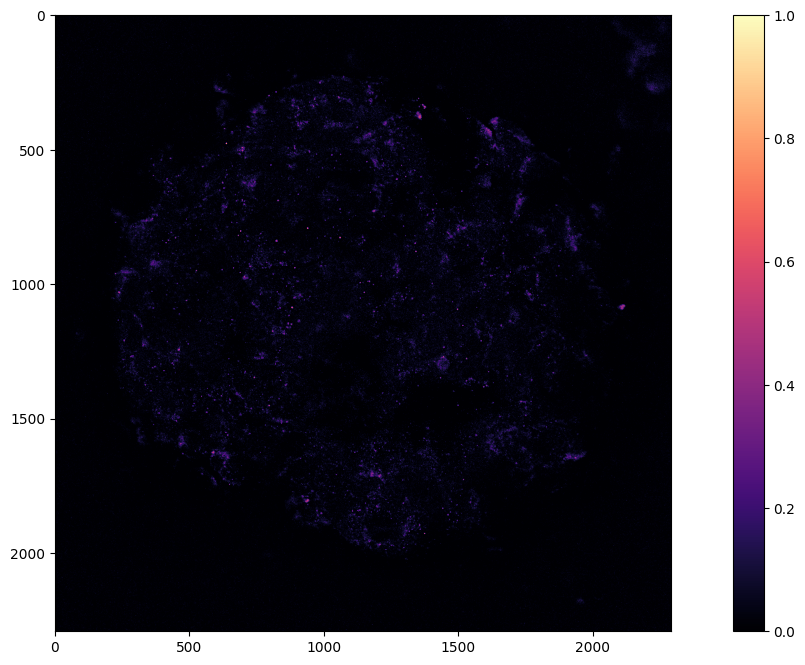

In [8]:
# --------- Visualize the result ---------

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(hdome_adapteq[z_slice], cmap='magma')
fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap='magma'), ax=ax)


# # Saving (Local)
# filename = "/slice_4/sox2_processed.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/sox2_processed.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)




plt.show()  # Display the plot

## Nuclei Channel

In [38]:
# 0. Converting the original image to float (originally it's a 'uint16')
image_3d = np.copy(nuclei_channel)
image_2d = image_3d[z_slice]

image_normalized = image_3d.astype(np.float32) / 65535.0

# 1. Adaptive Histogram Equalization on the 3D image
image_3d_equalized = exposure.equalize_adapthist(image_3d)

# 2. Extract a 2D slice from the equalized 3D image
image_2d_equalized = image_3d_equalized[z_slice]

# 3. Morphological opening to remove small noise
selem = morphology.disk(2)  # using a disk-shaped structuring element of radius 2
image_2d_opened = morphology.opening(image_2d_equalized, selem)
image_2d_opened = morphology.area_closing(image_2d_opened, area_threshold=150)

# 4. Bilateral Filtering (denoising without bluring edges)
image_opened_bilateral = denoise_bilateral(image_2d_opened, sigma_color=0.05, sigma_spatial=15)

# 5. Load pretrained StarDist 2D model for fluorescent images
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Perform instance segmentation on the normalized binary image
labels, details = model.predict_instances(image_opened_bilateral)

# Extract boundaries from the labels
boundaries = find_boundaries(labels)

# ----------------------------------

# Overlay boundaries on the opened, filtered image
overlay = np.copy(image_opened_bilateral)
overlay[boundaries] = np.max(image_opened_bilateral)  # setting the boundary pixels to the maximum value of the image for visualization



Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2023-11-06 22:19:41.041334: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 679477248 exceeds 10% of free system memory.


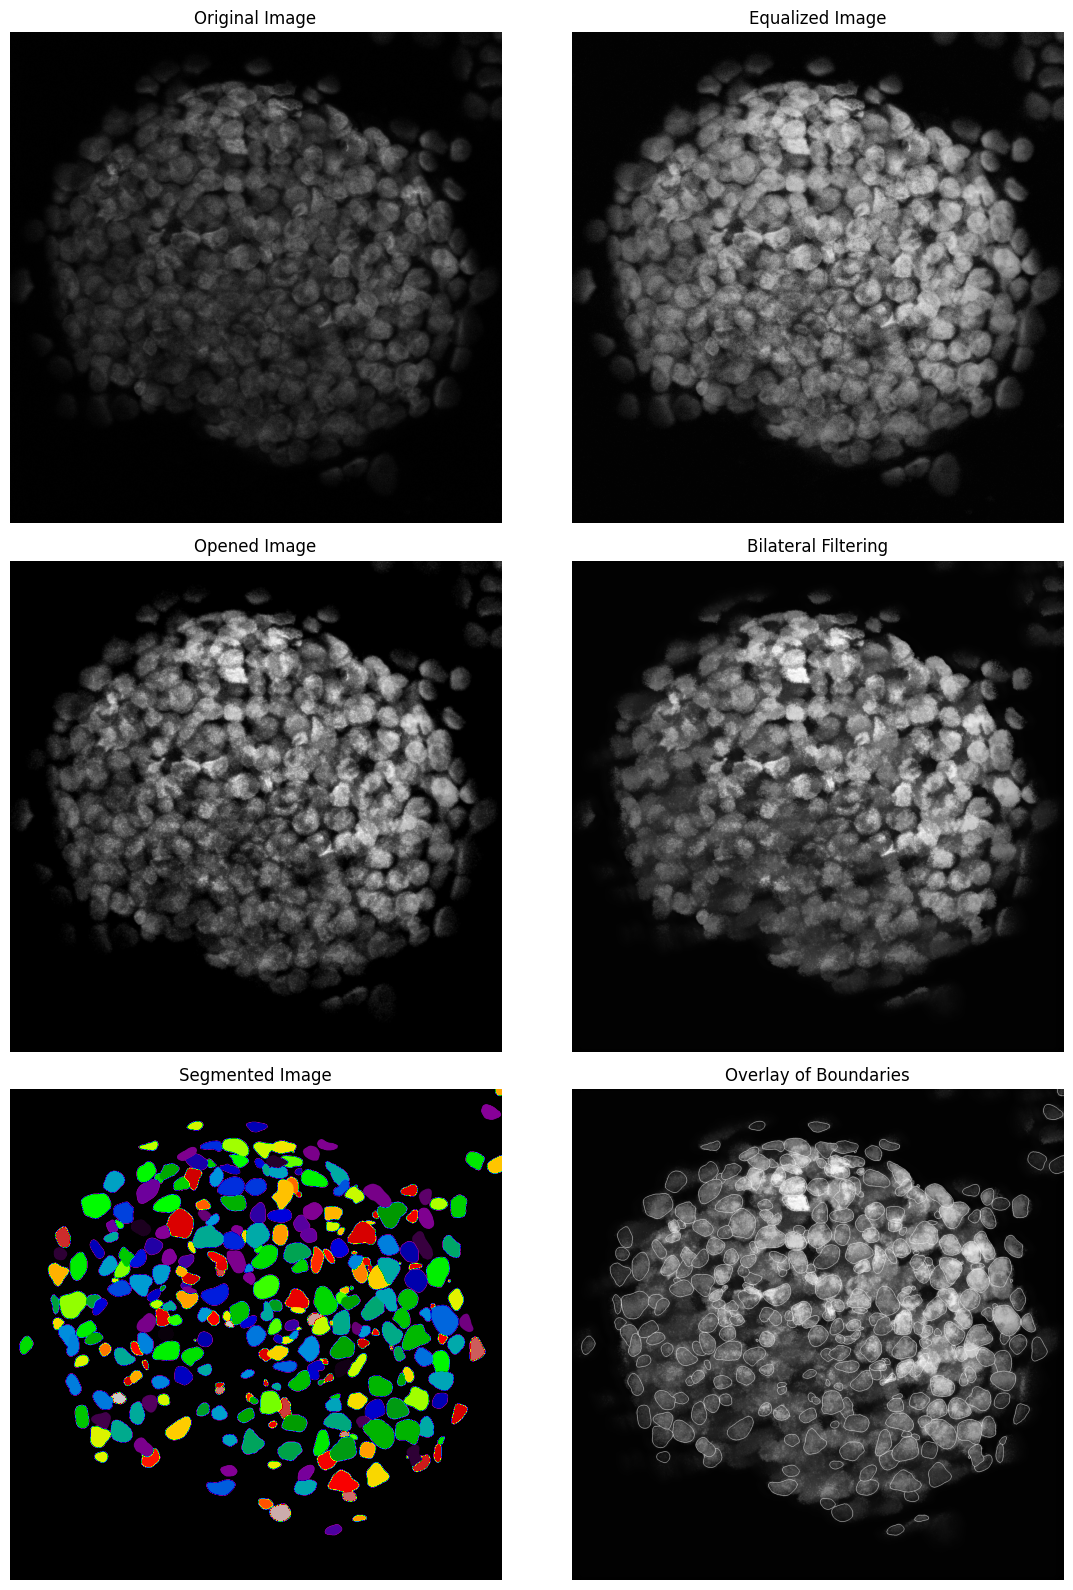

In [41]:
# --------- Visualize the result ---------


# Plotting the original, equalized, opened, and segmented images
fig, axes = plt.subplots(3, 2, figsize=(12, 16))
ax = axes.ravel()

ax[0].imshow(image_2d, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(image_2d_equalized, cmap='gray')
ax[1].set_title("Equalized Image")
ax[1].axis('off')

ax[2].imshow(image_2d_opened, cmap='gray')
ax[2].set_title("Opened Image")
ax[2].axis('off')

ax[3].imshow(image_opened_bilateral, cmap='gray')
ax[3].set_title("Bilateral Filtering")
ax[3].axis('off')

ax[4].imshow(labels, cmap='nipy_spectral')
ax[4].set_title("Segmented Image")
ax[4].axis('off')

ax[5].imshow(overlay, cmap='gray')
ax[5].set_title("Overlay of Boundaries")
ax[5].axis('off')

plt.tight_layout()


# # Saving (Local)
# filename = "/slice_4/nuclei_processing.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/sox2_processed.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)



plt.show()

## Generating the DataFrame

In [11]:
# --------- Generation of the DataFrame with geometrical properties of segmented objects ---------

spacing = (1.2364633517553391e-7, 1.2364633517553391e-7)  # in meters for (y, x) dimensions

properties = [
    "label", "area", "centroid", "equivalent_diameter", "bbox_area", "convex_area", "filled_area", "major_axis_length",
    "minor_axis_length", "bbox", "weighted_centroid", "coords",
    "eccentricity", "euler_number", "extent",
    "feret_diameter_max", "max_intensity", "mean_intensity", "min_intensity",
    "orientation", "perimeter", "solidity"
]

# Extract the region properties
regions = regionprops_table(labels, intensity_image=image_opened_bilateral, properties=properties) # , spacing=spacing

# Convert the result to a DataFrame
df = pd.DataFrame(regions)
df


label    area   centroid-0   centroid-1  equivalent_diameter  bbox_area  \
0        1  2928.0   336.119536  1003.001366            61.057722     3888.0   
1        2  4097.0  1143.781792   725.897242            72.225082     5320.0   
2        3  4783.0  1303.789672  1549.289985            78.037842     6960.0   
3        4  5471.0   650.496801   610.031804            83.461929     7584.0   
4        5  4215.0   343.074259  1239.216845            73.257796     6448.0   
..     ...     ...          ...          ...                  ...        ...   
296    297  2519.0  1072.697896  1415.281064            56.632945     4779.0   
297    298  6197.0  1978.480878  1259.691302            88.827166     8134.0   
298    299   116.0   898.706897  2046.241379            12.153016      156.0   
299    300  1010.0  1099.429703  1021.994059            35.860451     1496.0   
300    301  2761.0  1444.785223   507.802246            59.290930     4015.0   

     convex_area  filled_area  major_axis_length  minor_axis_length  ...  \
0         3117.0       2928.0          75.252589          52.102354  ...   
1         4160.0       4097.0          76.770961          68.162206  ...   
2         4874.0       4783.0         100.779594          61.433336  ...   
3         5552.0       5471.0          98.198499          71.280951  ...   
4         4398.0       4215.0         100.105184          54.770636  ...   
..           ...          ...                ...                ...  ...   
296       2955.0       2519.0          79.073962          45.829585  ...   
297       6281.0       6197.0          98.254018          80.705840  ...   
298        124.0        116.0          13.623074          11.003209  ...   
299       1070.0       1010.0          44.019700          29.895665  ...   
300       2935.0       2761.0          67.953703          52.483740  ...   

     eccentricity  euler_number    extent  feret_diameter_max  max_intensity  \
0        0.721546             1  0.753086           77.252832       0.650847   
1        0.460105             1  0.770113           77.665951       0.542441   
2        0.792724             1  0.687213          105.261579       0.755263   
3        0.687815             1  0.721387           99.368003       0.550419   
4        0.837047             1  0.653691          104.479663       0.770128   
..            ...           ...       ...                 ...            ...   
296      0.814916             1  0.527098           83.198558       0.518417   
297      0.570353             1  0.761864          100.687636       0.190788   
298      0.589609             1  0.743590           14.317821       0.331281   
299      0.734006             1  0.675134           45.650849       0.468122   
300      0.635203             1  0.687671           74.525164       0.322483   

     mean_intensity min_intensity  orientation   perimeter  solidity  
0          0.366038      0.093204     1.367168  218.066017  0.939365  
1          0.322416      0.082954    -1.286684  238.793939  0.984856  
2          0.549903      0.193432    -0.748998  274.936075  0.981330  
3          0.357820      0.147641     1.152111  281.563492  0.985411  
4          0.574122      0.161743     1.427078  269.421356  0.958390  
..              ...           ...          ...         ...       ...  
296        0.323519      0.138507    -0.992561  227.965512  0.852453  
297        0.102544      0.031052     1.569849  297.078210  0.986626  
298        0.211591      0.077986    -0.484516   38.970563  0.935484  
299        0.271263      0.088830     1.087937  127.539105  0.943925  
300        0.211349      0.110574     1.325564  210.687338  0.940716  

[301 rows x 27 columns]

In [43]:
# --------- Voronoi Teselation ---------

# Convert centroids to integer coordinates for seeding
centroids = df[['centroid-0', 'centroid-1']].to_numpy().astype(int)

# Using the centroids as the points for Voronoi, but making sure we're using (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Note the coordinate reversal here
vor = Voronoi(points)


In [44]:
# --------- Counting Fluorescence Intensity in each region ---------

hdome3 = hdome[z_slice]

# Create a blank image for Voronoi segmentation
voronoi_regions = np.zeros_like(hdome3, dtype=int)

# Generate Voronoi regions
points = np.array([(c, r) for r, c in centroids])
vor = Voronoi(points)

intensity_sums = [0] * len(centroids)  # Initialize intensity sums with zeros

for region in vor.regions:
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon = [vor.vertices[i] for i in region]
        if len(polygon) > 2:  # Ensure that we have a valid polygon with more than 2 vertices
            rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], voronoi_regions.shape)

            # Determine which centroid this region belongs to based on proximity
            region_centroid = (np.mean(rr), np.mean(cc))
            idx = np.argmin([distance.euclidean(region_centroid, cent) for cent in centroids])

            voronoi_regions[rr, cc] = idx + 1  # Add 1 to avoid using zero as a label
            intensity_sums[idx] += np.sum(hdome3[rr, cc])  # Update the intensity sum for this region

# Add the intensity sums to the dataframe
df['Fluorescence_Intensity'] = intensity_sums

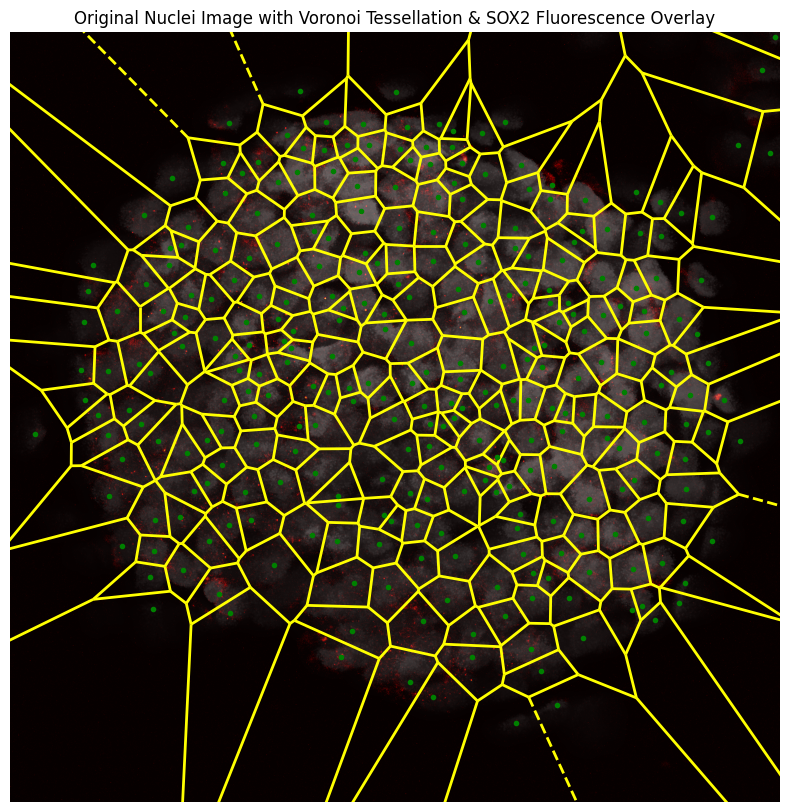

In [46]:
# --------- Regions, Nuclei and SOX2 Overlay ---------

# Using the centroids as the points for Voronoi, ensuring (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Coordinate reversal
vor = Voronoi(points)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_opened_bilateral, cmap='gray')

# Overlay the Voronoi diagram without the original Voronoi points
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Overlay the fluorescence channel using a colormap. Here, I assume fluorescence_image represents your fluorescence channel.
ax.imshow(hdome[z_slice], cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids on top
for (r, c) in centroids:
    ax.plot(c, r, 'g.')  # Using (x, y) convention

ax.set_xlim([0, labels.shape[1]])
ax.set_ylim([labels.shape[0], 0])  # Invert y-axis to match image coordinates
ax.set_title('Original Nuclei Image with Voronoi Tessellation & SOX2 Fluorescence Overlay')
plt.axis('off')


# # Saving (Local)
# filename = "Devel/experimental_images/results/slice_4/nuclei_voronoi_sox2.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/nuclei_voronoi_sox2.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)



plt.show()

## Stem and Differentiated Cell Clustering

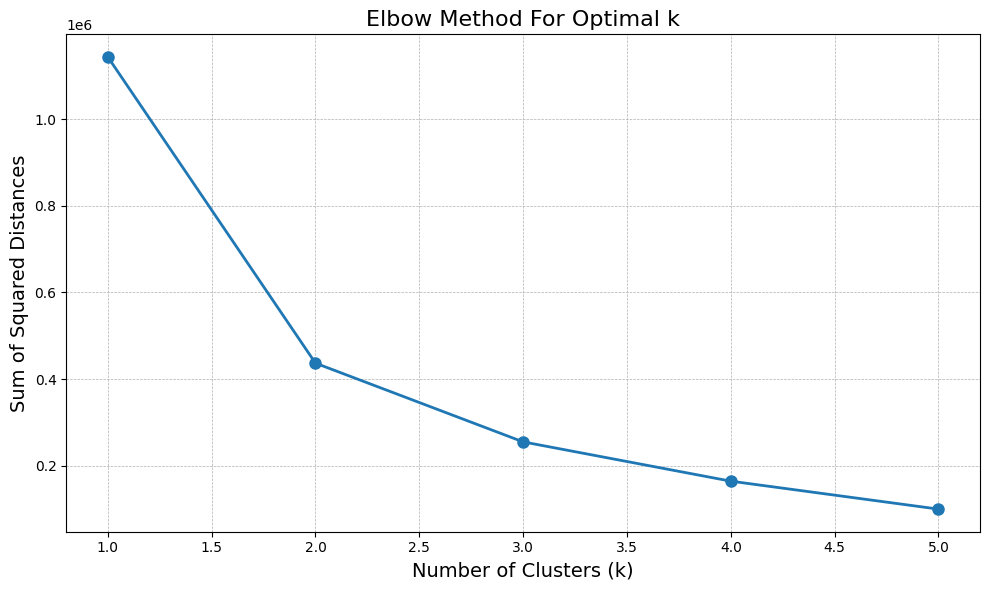

In [15]:
# --------- Elbow plot for cluster number ---------

# Extract fluorescence intensity values from the DataFrame
fluorescence_intensities = df['Fluorescence_Intensity'].values.reshape(-1, 1)

# Calculate sum of squared distances (SSD) for different values of k
ssd = []
range_n_clusters = range(1, 6)

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init='auto', random_state=42)
    kmeans.fit(fluorescence_intensities)
    ssd.append(kmeans.inertia_)

# Plot the SSD values against k to visualize the elbow
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Sum of Squared Distances', fontsize=14)
plt.title('Elbow Method For Optimal k', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [25]:
# Filter out regions with Fluorescence_Intensity <= 180
filtered_df = df[df['Fluorescence_Intensity'] <= 180].copy()  # Use copy() to ensure we're working on a copy

# Reshape the Fluorescence_Intensity data for clustering
X = filtered_df['Fluorescence_Intensity'].values.reshape(-1, 1)

# Perform GMM clustering with k=2
gmm = GaussianMixture(n_components=2)
gmm.fit(X)


# Get the clustering labels
labels = gmm.predict(X)

# Compute the mean fluorescence intensity for each cluster
cluster_means = np.array([filtered_df['Fluorescence_Intensity'][labels == i].mean() for i in np.unique(labels)])

# Identify the labels of the clusters with higher and lower mean intensities
label_higher_intensity = cluster_means.argmax()
label_lower_intensity = cluster_means.argmin()

# Replace labels to ensure cluster with higher mean intensity is labeled 1 and the other as 0
labels[labels == label_higher_intensity] = 2  # Use 2 as a temporary label to avoid confusion during replacement
labels[labels == label_lower_intensity] = 0
labels[labels == 2] = 1  # Finally replace temporary label 2 with 1

# Assign the corrected labels to the filtered dataframe
filtered_df.loc[:, 'filtered_GMM_stemness'] = labels


# Assign the corrected labels to the filtered dataframe
filtered_df.loc[:, 'filtered_GMM_stemness'] = labels

# Create a new column in the original dataframe for the mapped labels, initialized to NaN
df['filtered_GMM_stemness'] = np.nan

# Map the GMM_stemness labels back to the original df
df.update(filtered_df['filtered_GMM_stemness'])

# Set the values to 1 where Fluorescence_Intensity > 180
df.loc[df['Fluorescence_Intensity'] > 180, 'filtered_GMM_stemness'] = 1


In [31]:
df[['label', 'Fluorescence_Intensity', 'filtered_GMM_stemness']].loc[df['Fluorescence_Intensity']>85].loc[df['Fluorescence_Intensity']<95].sort_values(by='Fluorescence_Intensity')

label  Fluorescence_Intensity  filtered_GMM_stemness
158    159               85.042206                    0.0
135    136               85.241138                    0.0
262    263               85.644526                    0.0
109    110               86.296933                    0.0
145    146               88.278447                    0.0
69      70               88.661616                    0.0
31      32               89.574472                    1.0
199    200               89.997887                    1.0
198    199               90.380163                    1.0
183    184               90.765072                    1.0
160    161               90.911650                    1.0
42      43               91.442115                    1.0
186    187               92.869596                    1.0
14      15               94.622522                    1.0

In [53]:
# the number of one's is the number of CSCs
filtered_GMM_stemness_ones = df['filtered_GMM_stemness'].sum()
print(f"Number of CSCs according to filtered_GMM_stemness: {filtered_GMM_stemness_ones}")
print(f'They represent a {filtered_GMM_stemness_ones / df.shape[0] * 100:.4f}% of the total number of cells')
print('The threshold is roughly at a fluorescence intensity of 89.')

Number of CSCs according to filtered_GMM_stemness: 102.0
They represent a 33.8870% of the total number of cells
The threshold is roughly at a fluorescence intensity of 89.


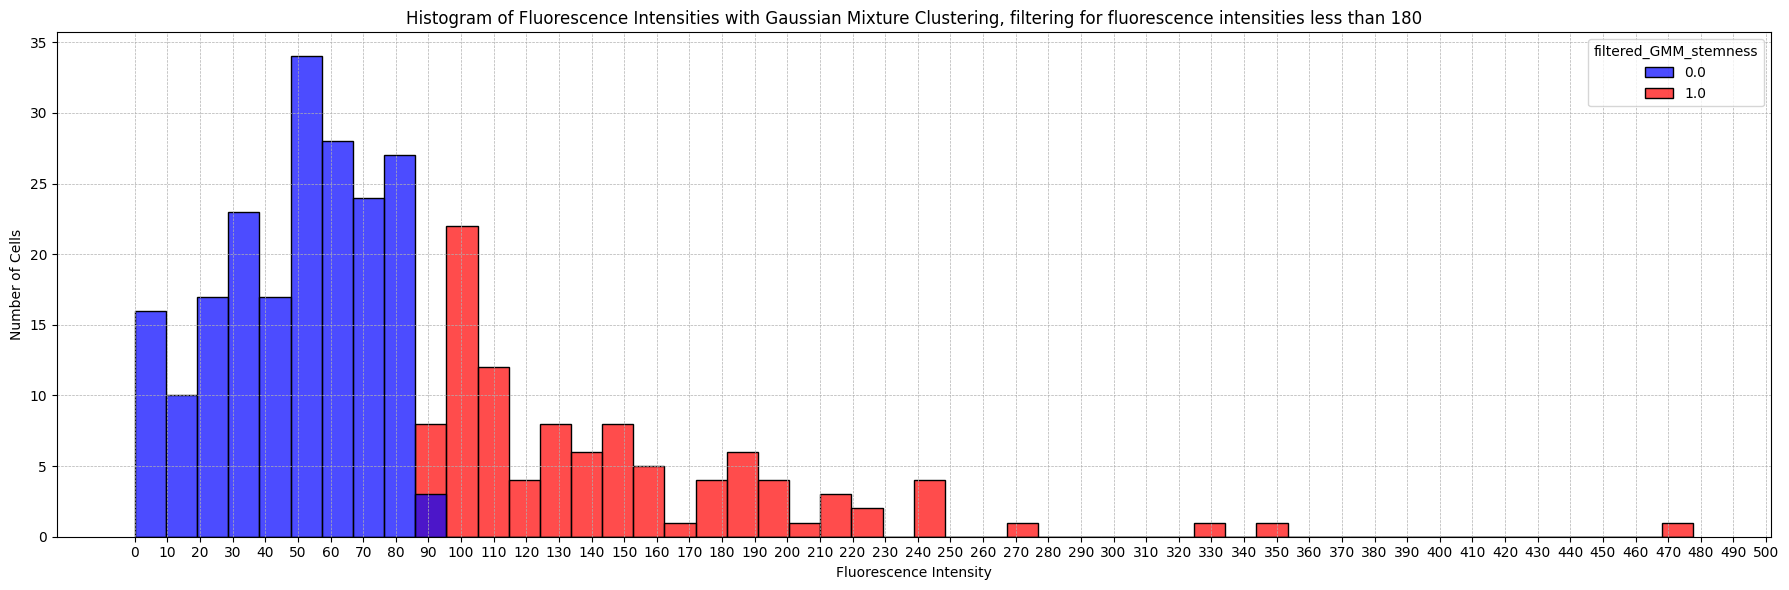

In [29]:
plt.figure(figsize=(18, 6))
sns.histplot(df, x='Fluorescence_Intensity', hue='filtered_GMM_stemness', bins=50, palette=['blue', 'red'], element='bars', stat='count', common_norm=False, alpha=0.7)

# Plot customization to resemble the original plot
plt.title('Histogram of Fluorescence Intensities with Gaussian Mixture Clustering, filtering for fluorescence intensities less than 180')
plt.xlabel('Fluorescence Intensity')
plt.ylabel('Number of Cells')

# Set x-ticks starting from 0 and every 10 units
xmax = plt.xlim()[1]  # Get the current maximum xlim value
plt.xticks(np.arange(0, xmax+1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()



# # Save the plot to your computer
# filename = "/content/histogram_GMM-means-filtered-intensity<180_clustering.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)



plt.show()

In [49]:
# Save the DataFrame to a CSV

# Define the directory path
directory = "./results/slice_4/"
csv_file_path = os.path.join(directory, "cell_features_slice_4.csv")

# Save the DataFrame to a CSV in the specified directory
# df.to_csv(csv_file_path, index=False)


In [ ]:
# Read the previously saved DataFrame
# df = pd.read_csv(csv_file_path)

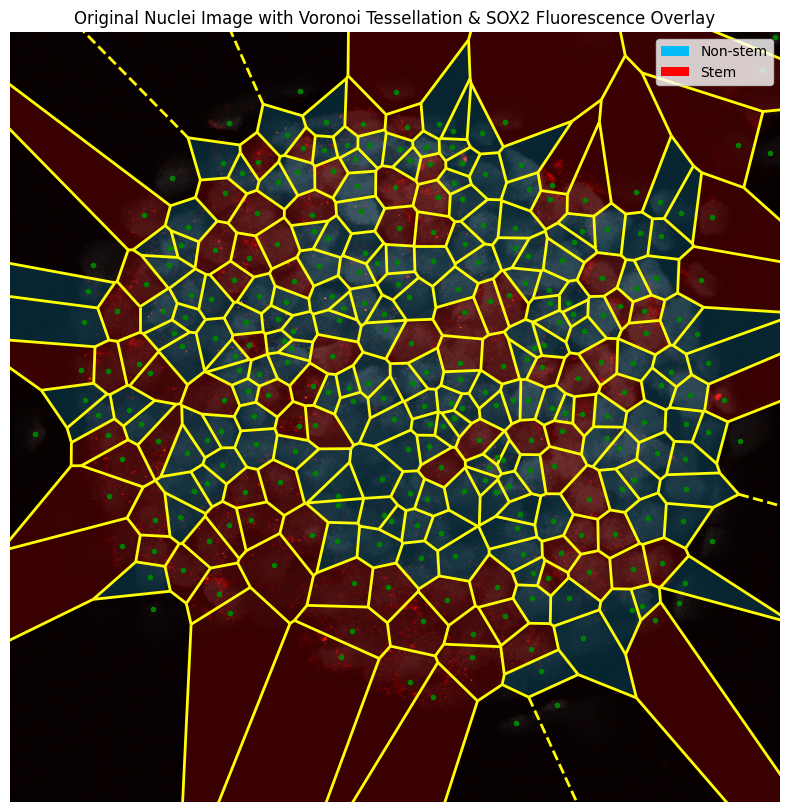

In [60]:


# Define a soft, pastel colormap
pastel_cmap = ListedColormap(['#02bbf7', '#fc0303'])  # modified colors as requested

# Using the centroids as the points for Voronoi, ensuring (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Coordinate reversal
vor = Voronoi(points)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_opened_bilateral, cmap='gray')

# Create an empty image to overlay the Voronoi regions
voronoi_overlay = np.zeros(image_opened_bilateral.shape + (4,), dtype=np.uint8)  # Note the 4 for RGBA

# Fill the Voronoi regions with color based on 'filtered_GMM_stemness'
for point_idx, region_idx in enumerate(vor.point_region):
    region = vor.regions[region_idx]
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon = [vor.vertices[i] for i in region]
        rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], image_opened_bilateral.shape)

        # Get the color based on 'filtered_GMM_stemness'
        stemness_value = df.at[point_idx, 'filtered_GMM_stemness']
        color = pastel_cmap(stemness_value)

        voronoi_overlay[rr, cc] = np.array(color)*255  # Assuming 'color' is an RGBA tuple

# Display the colored Voronoi overlay
ax.imshow(voronoi_overlay, alpha=0.5)  # Adjust alpha for desired transparency

# Overlay the Voronoi diagram without the points, with yellow lines for boundaries
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Overlay the fluorescence channel using a colormap. Assume 'hdome[z_slice]' represents your fluorescence channel.
ax.imshow(hdome[z_slice], cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids on top
for (r, c) in centroids:
    ax.plot(c, r, 'g.')  # green dot for each centroid

# Legend for the Voronoi region colors
legend_labels = [Patch(facecolor=pastel_cmap(0), label='Non-stem'), 
                 Patch(facecolor=pastel_cmap(1), label='Stem')]
ax.legend(handles=legend_labels, loc='upper right')

ax.set_xlim([0, image_opened_bilateral.shape[1]])
ax.set_ylim([image_opened_bilateral.shape[0], 0])  # Invert y-axis to match image coordinates
ax.set_title('Original Nuclei Image with Voronoi Tessellation & SOX2 Fluorescence Overlay')
plt.axis('off')

plt.show()
